# 1. Introduction

In [ ]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz

--2023-07-27 17:04:44--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.105.124, 54.231.132.145, 3.5.25.254, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.105.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361408056 (345M) [application/x-gzip]
Saving to: ‘fruits_dataset.tar.gz’

fruits_dataset.tar. 100%[===================>] 344.67M  42.6MB/s    in 7.4s    

2023-07-27 17:04:52 (46.3 MB/s) - ‘fruits_dataset.tar.gz’ saved [361408056/361408056]



In [ ]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

extract_tar_gz('/content/fruits_dataset.tar.gz', '/content')

In [ ]:
import tensorflow as tf

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='fruits/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(100, 100),
    validation_split=0.25,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='fruits/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(100, 100),
    validation_split=0.25,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='fruits/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(100, 100))

Found 67692 files belonging to 131 classes.
Using 50769 files for training.
Found 67692 files belonging to 131 classes.
Using 16923 files for validation.
Found 22688 files belonging to 131 classes.


# 2. Preprocessing and Exploring the Dataset

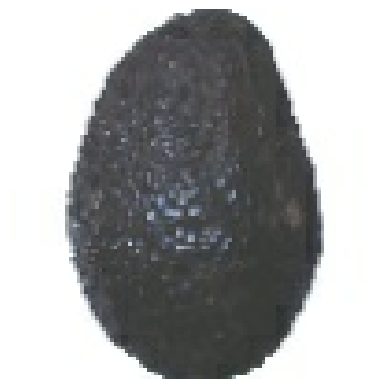

In [ ]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt

normalization_layer = layers.Rescaling(scale=1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

train_set_elem = train_set_normalized.take(1)
for images, labels in train_set_elem:
    images = images.numpy()

plt.imshow(images[0])
plt.axis('off')
plt.show()

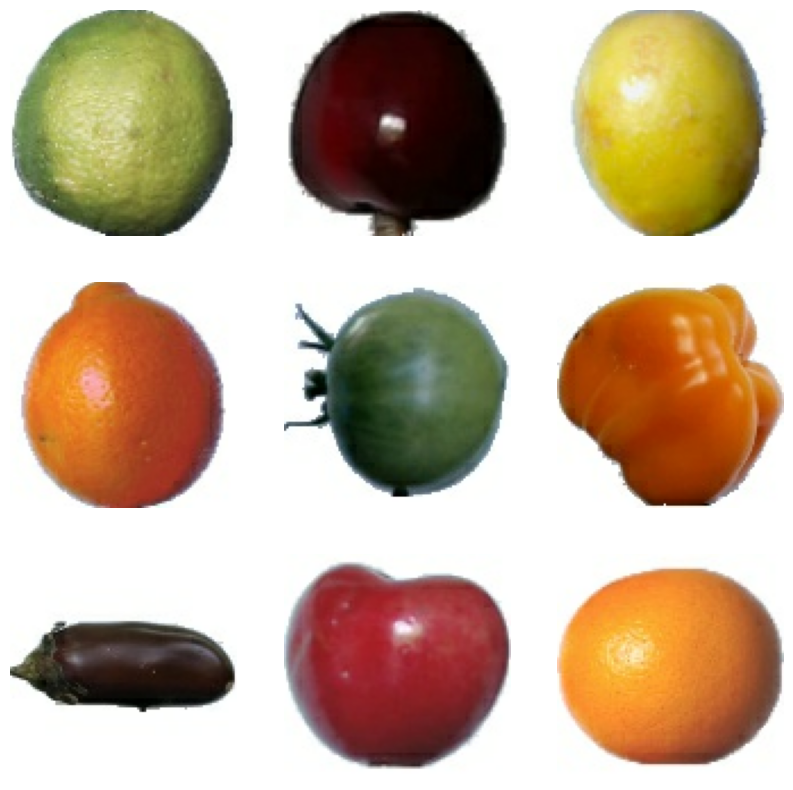

In [ ]:
import numpy as np

selected_indices = np.linspace(1, 255, 9).astype(int)

plt.figure(figsize=(10, 10))

for i, index in enumerate(selected_indices, 1):
    image = images[index]
    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.axis('off')

plt.show()

# 3. Residual Connections I: Creating a Residual Block

In [ ]:
from tensorflow.keras import initializers

weight_initializer = initializers.HeNormal()

def resnet_block(input_layer, num_filters):

    shortcut = input_layer

    output = layers.Conv2D(filters=num_filters, kernel_size=3, strides=1, padding='same', kernel_initializer=weight_initializer)(input_layer)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)

    output = layers.Conv2D(filters=num_filters, kernel_size=3, strides=1, padding='same', kernel_initializer=weight_initializer)(output)
    output = layers.BatchNormalization()(output)

    output = layers.Add()([output, shortcut])
    output = layers.ReLU()(output)

    return output

# 4. ResNet18 I: The First Two Residual Blocks

In [ ]:
from tensorflow.keras import Model, Input

def resnet18(num_classes):
    input_layer = Input(shape=(100, 100, 3))

    conv = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', kernel_initializer=weight_initializer)(input_layer)
    conv = layers.BatchNormalization()(conv)
    conv = layers.ReLU()(conv)
    conv = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv)

    block1 = resnet_block(conv, 64)
    block2 = resnet_block(block1, 64)

    global_pooling = layers.GlobalAveragePooling2D()(block2)

    output = layers.Dense(num_classes)(global_pooling)

    model = Model(inputs=input_layer, outputs=output)

    return model

model = resnet18(131)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 50, 50, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 50, 50, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                            

# 5. ResNet18 II: Adding More Residual Blocks

In [ ]:
def resnet18(num_classes):
    input_layer = Input(shape=(100, 100, 3))

    conv = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', kernel_initializer=weight_initializer)(input_layer)
    conv = layers.BatchNormalization()(conv)
    conv = layers.ReLU()(conv)
    conv = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv)

    block1 = resnet_block(conv, 64)
    block2 = resnet_block(block1, 64)

    block3 = resnet_block(block2, 128)
    block4 = resnet_block(block3, 128)

    global_pooling = layers.GlobalAveragePooling2D()(block4)

    output = layers.Dense(num_classes)(global_pooling)

    model = Model(inputs=input_layer, outputs=output)

    return model

model = resnet18(131)
model.summary()

ValueError: ignored

# 6. Residual Connections II: Downsampling

In [ ]:
def resnet_block(input_layer, num_filters, downsample=False):

    if downsample:
        stride = 2
        shortcut = layers.Conv2D(filters=num_filters, kernel_size=1, strides=stride, padding='same', kernel_initializer=weight_initializer)(input_layer)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        stride = 1
        shortcut = input_layer

    output = layers.Conv2D(filters=num_filters, kernel_size=3, strides=stride, padding='same', kernel_initializer=weight_initializer)(input_layer)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)

    output = layers.Conv2D(filters=num_filters, kernel_size=3, strides=1, padding='same', kernel_initializer=weight_initializer)(output)
    output = layers.BatchNormalization()(output)

    output = layers.Add()([output, shortcut])
    output = layers.ReLU()(output)

    return output

def resnet18(num_classes):
    input_layer = Input(shape=(100, 100, 3))

    conv = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', kernel_initializer=weight_initializer)(input_layer)
    conv = layers.BatchNormalization()(conv)
    conv = layers.ReLU()(conv)
    conv = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv)

    block1 = resnet_block(conv, 64)
    block2 = resnet_block(block1, 64)

    block3 = resnet_block(block2, 128, downsample=True)
    block4 = resnet_block(block3, 128)

    block5 = resnet_block(block4, 256, downsample=True)
    block6 = resnet_block(block5, 256)

    block7 = resnet_block(block6, 512, downsample=True)
    block8 = resnet_block(block7, 512)

    global_pooling = layers.GlobalAveragePooling2D()(block8)

    output = layers.Dense(num_classes)(global_pooling)

    model = Model(inputs=input_layer, outputs=output)

    return model

model = resnet18(131)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 50, 50, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 50, 50, 64)  256         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                            

# 7. Training and Evaluating the Model

In [12]:
opt = tf.keras.optimizers.SGD()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy'])

model.fit(train_set_normalized, epochs=10, validation_data=validation_set_normalized)

test_loss, test_acc = model.evaluate(test_set_normalized)

print(f"Test set accuracy: {test_acc}")

Epoch 1/10
199/199 [==============================] - 66s 236ms/step - loss: 3.1462 - accuracy: 0.4966 - val_loss: 2.7811 - val_accuracy: 0.4696
Epoch 2/10
199/199 [==============================] - 51s 256ms/step - loss: 1.0824 - accuracy: 0.9115 - val_loss: 0.7135 - val_accuracy: 0.9543
Epoch 3/10
199/199 [==============================] - 47s 235ms/step - loss: 0.4494 - accuracy: 0.9750 - val_loss: 0.3220 - val_accuracy: 0.9842
Epoch 4/10
199/199 [==============================] - 48s 238ms/step - loss: 0.2458 - accuracy: 0.9902 - val_loss: 0.1891 - val_accuracy: 0.9939
Epoch 5/10
199/199 [==============================] - 52s 258ms/step - loss: 0.1566 - accuracy: 0.9958 - val_loss: 0.1322 - val_accuracy: 0.9966
Epoch 6/10
199/199 [==============================] - 52s 260ms/step - loss: 0.1115 - accuracy: 0.9977 - val_loss: 0.0950 - val_accuracy: 0.9979
Epoch 7/10
199/199 [==============================] - 49s 243ms/step - loss: 0.0850 - accuracy: 0.9984 - val_loss: 0.0761 - val_ac